In this notebook, I will investigate and visualize the best way to implement some mathematical functions within a random scrape delay algorithm. The functions will calculate the upper limit to set for a range of numbers from which a random number will be selected, the selected random number will act as our delay time for each individual scrape job. The logic behind having math equations calculate each random delay upper limit, is to achieve a balance between speed and not accidently DDoSing the job boards being scraped from. 

The mathematical functions are called(hard, linear, and Richards/Sigmoid). The user also has the option to turn off random delay and just use the equations to determine per scrape delay. I used [this article](https://streamhpc.com/blog/2012-07-16/how-expensive-is-an-operation-on-a-cpu/) to help re-write the equations to be the least computationally expensive.

Note: The user also the option to turn off randomness, and just use the function to define rates of delay.

In [2]:
## Uncomment commented out code if any packages are missing.
#import sys, subprocess
#for pkg in ['scipy', 'matplotlib']: subprocess.check_call([sys.executable, "-m", "pip", "install", "--user", pkg])
from math import sqrt, exp, log
import matplotlib.pyplot as plt

DESCRIPTION FOR TWO FUNCTIONS BELOW

In [3]:
def h_delay(_list, delay: int = 1):
    if isinstance(_list, int):
        delays = [delay] * _list
    else:
        delays = [delay] * len(_list)
    delays[0] = 0
    return delays
def lin_delay(_list, delay: int = 5):
    if (its := 5*delay) <= 1:
        return h_delay(_list, delay)
    else:
        if isinstance(_list, int):
            delays = [*range(_list)]
        else:
            delays = [*range(len(_list))]
        delays[0:its] = [.2*x for x in delays[0:its]]
        delays[its:] = [delay]*(len(delays) - its)
        return delays

The equation below is called  Richards Curve which is an extension of the sigmoid function, which is modified to have finer control of our S curves behavior. More info can be found on it [here](https://en.wikipedia.org/wiki/Generalised_logistic_function).

In [4]:
def rich_delay(_list, delay: int = 15):
    gr = sqrt(delay)*4
    y_0 = 4*delay
    if isinstance(_list, int):
        delays = [delay / (1 + (y_0 * exp(-x/gr))) for x in range(_list)]
    else:
        delays = [delay / (1 + (y_0 * exp(-x/gr))) for x in _list]
    delays[0] = 0
    return delays

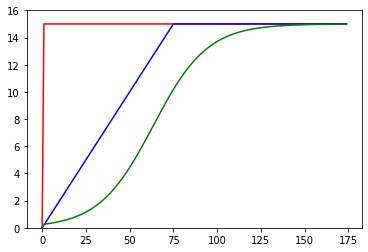

In [5]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(range(175), h_delay(175, 15), 'r')
ax.plot(range(175), lin_delay(175, 15), 'b')
ax.plot(range(175), rich_delay(175), 'g')
ax.set(ylim=[0, 16])
plt.show()

Next lets see the integrals of our equations

In [6]:
from matplotlib.patches import Polygon
from numpy import trapz as auc

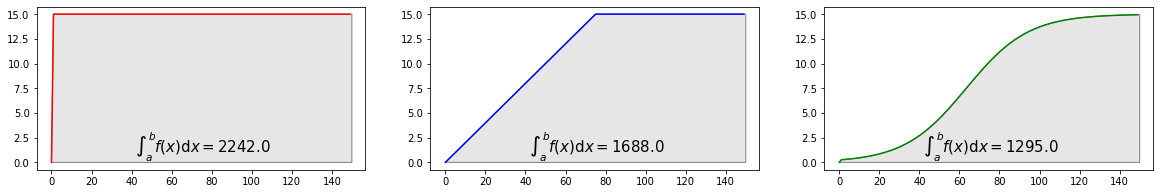

In [7]:
#fig, ax = plt.subplots(ncols=3, sharex='col', sharey='row')
# To do, figure out how to share y-axis and display the integrals. Also put in latex our equations 
## Defining our points to plot
ix = [*range(151)]
iH_y = h_delay(ix, 15)
iL_y = lin_delay(ix, 15)
iR_y = rich_delay(ix, 15)
a = 1
b = 150
# Setup our plot.
fig = plt.figure(figsize=(20,3))
ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132, sharey = ax1)
ax3 = fig.add_subplot(133, sharey = ax1)
ax1.plot(range(150), h_delay(150, 15), 'r')
ax2.plot(range(150), lin_delay(150, 15), 'b')
ax3.plot(range(150), rich_delay(150, 15), 'g')
ax1.text(0.5*(a + b), 1, r"$\int_a^b f(x)\mathrm{d}x=$" + str(round(auc(iH_y, dx=1))),
        horizontalalignment='center', fontsize=15)
ax2.text(0.5*(a + b), 1, r"$\int_a^b f(x)\mathrm{d}x=$" + str(round(auc(iL_y, dx=1))),
        horizontalalignment='center', fontsize=15)
ax3.text(0.5*(a + b), 1, r"$\int_a^b f(x)\mathrm{d}x=$" + str(round(auc(iR_y, dx=1))),
        horizontalalignment='center', fontsize=15)
verts1 = [(a,0), *zip(ix, iH_y), (b, 0)] 
verts2 = [(a,0), *zip(ix, iL_y), (b, 0)] 
verts3 = [(a,0), *zip(ix, iR_y), (b, 0)]
poly1 = Polygon(verts1, facecolor='0.9', edgecolor='0.5')
poly2 = Polygon(verts2, facecolor='0.9', edgecolor='0.5')
poly3 = Polygon(verts3, facecolor='0.9', edgecolor='0.5')
ax1.add_patch(poly1)
ax2.add_patch(poly2)
ax3.add_patch(poly3)
plt.show()

Next, lets time our calculations and see how fast they run.

In [8]:
%timeit h_delay(10000, delay = 15)

22.4 µs ± 332 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [9]:
%timeit lin_delay(10000, delay = 15)

243 µs ± 2.4 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [10]:
%timeit rich_delay(10000, delay = 15)

2.37 ms ± 38.6 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


The Richards curve calculation is way slower then the other functions, most likely due to the heavy computation costs of the math being used. To make it faster, the equation will be rewritten in form for use with the expit function in SciPy which calculates a Sigmoid Curve. 

In [11]:
from scipy.special import expit
from numpy import array, arange
from math import log

In [12]:
def rich_delay_1(_list, delay: int = 15):
    gr = sqrt(delay)*4
    y_0 = log(4*delay)
    if isinstance(_list, int):
        delays = delay * expit(arange(_list)/gr - y_0)
    else:
        delays = delay * expit(array(_list)/gr - y_0)
    delays[0] = 0
    return delays

In [13]:
%timeit rich_delay_1(10000, delay = 15)

147 µs ± 828 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


From the looks of it our Richards Curve is way faster now, and we have our functions for calculating delays or random delay limits.